In [72]:
#importing necessary libraries
import numpy as np
import pandas as pd
from keras.applications import imagenet_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications import VGG16
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
import matplotlib.pyplot as plt

In [73]:
# reading data from csv
data = pd.read_csv("../input/labeldatacsv/label-data-avantari.csv")

In [74]:
# displays head of dataframe
data.head()

,image,cluster
0,4642.jpg,0
1,4185.jpg,0
2,3680.jpg,0
3,2026.jpg,0
4,1824.jpg,0


In [75]:
# get the info of data frame 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4738 entries, 0 to 4737
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    4738 non-null   object
 1   cluster  4738 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 74.2+ KB


In [76]:
# shuffle the data
import sklearn
nd = sklearn.utils.shuffle(data)

In [77]:
# after shuffle display head
nd.head()

,image,cluster
1904,4131.jpg,2
1557,1558.jpg,2
3922,914.jpg,6
2639,2224.jpg,4
4491,4127.jpg,7


In [78]:
def create_features(dataset, pre_model):
    '''
    Generates features for all the images in the dataset 
    provided using pretrained model
    
    Arguments 
    dataset : list of image paths (dtype : list)
    pre_model : instance of our pre-trained model (dtype : keras.Model)
    
    Returns : Returns the n-D array of encoded features
              for each image (dtype : numpy.ndarray)
    
    '''
    x_scratch = []
    c = 0
    # loop over the images
    for imagePath in dataset:
        # load the image path
        imagePath = "../input/datasetavantari/dataset/"+imagePath.split("/")[-1]
        # Convert the image pixels to a numpy array
        image = img_to_array(image)
        # expanding the dimensions ex our image shape is (224,224,3) so far 
        # but if we expand the dimensions it becomes (1, 224, 224, 3)
        image = np.expand_dims(image, axis=0)
        # subtracting the mean RGB pixel intensity from the ImageNet dataset
        image = imagenet_utils.preprocess_input(image)
        # add the image to the batch
        x_scratch.append(image)
    #to get (n, 224, 224, 3) as the dim of images 
    # where n is the number of images processed
    # it will return n-d array of features with shape (4738, 224, 224, 3) 
    # note:our dataset size is 4738
    x = np.vstack(x_scratch)
    # Pass x into pre_model to get encoded features
    features = pre_model.predict(x, batch_size=32)
    return features

In [79]:
# Split the data set into train val and test in the ratio of 60:20:20 respectively
train, validate, test = np.split(nd.sample(frac=1), [int(.6*len(nd)), int(.8*len(nd))])

In [80]:
# displays the len after split
print(len(train),len(validate),len(test))

2842 948 948


In [81]:
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(250,250,3))

In [82]:
# display summary
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0     

In [83]:
# generate features for train data
d = list(train['image'])
train_features = create_features(d,vgg_conv)

In [84]:
# generate features for validation data
d = list(validate['image'])
val_features = create_features(d,vgg_conv)

In [85]:
# generates features for test data
d = list(test['image'])
test_features = create_features(d,vgg_conv)

In [86]:
# Bulding CNN 
model_transfer = Sequential()
model_transfer.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
model_transfer.add(Dropout(0.2))
model_transfer.add(Dense(100, activation='relu'))
model_transfer.add(Dense(8, activation='softmax'))
model_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 808       
Total params: 52,108
Trainable params: 52,108
Non-trainable params: 0
_________________________________________________________________


In [87]:
# Creating a checkpointer
checkpointer = ModelCheckpoint(filepath='avantari.hdf5',
                               verbose=1,save_best_only=True)

In [88]:
from keras.utils import to_categorical

In [89]:
# converting our output label into array of index as 1 as our output layer is softmax
y_train = to_categorical(train['cluster'])
y_val = to_categorical(validate['cluster'])
y_test = to_categorical(test['cluster'])

In [90]:
# defining loss,optimizer and metrics for model
model_transfer.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
#training our model
history = model_transfer.fit(train_features, y_train, batch_size=12, epochs=5,
          validation_data=(val_features, y_val), callbacks=[checkpointer],
          verbose=1, shuffle=True)

Epoch 1/5
220/237 [==========================>...] - ETA: 0s - loss: 0.9898 - accuracy: 0.8670
Epoch 00001: val_loss improved from inf to 0.15891, saving model to avantari.hdf5
237/237 [==============================] - 1s 5ms/step - loss: 0.9308 - accuracy: 0.8737 - val_loss: 0.1589 - val_accuracy: 0.9715
Epoch 2/5
235/237 [============================>.] - ETA: 0s - loss: 0.2389 - accuracy: 0.9574
Epoch 00002: val_loss did not improve from 0.15891
237/237 [==============================] - 1s 4ms/step - loss: 0.2370 - accuracy: 0.9578 - val_loss: 0.1713 - val_accuracy: 0.9684
Epoch 3/5
226/237 [===========================>..] - ETA: 0s - loss: 0.1960 - accuracy: 0.9598
Epoch 00003: val_loss did not improve from 0.15891
237/237 [==============================] - 1s 4ms/step - loss: 0.1999 - accuracy: 0.9588 - val_loss: 0.1929 - val_accuracy: 0.9673
Epoch 4/5
237/237 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.9676
Epoch 00004: val_loss improved from 0.15891

In [91]:
# Ploting the Accuracy and loss during training and validation
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 

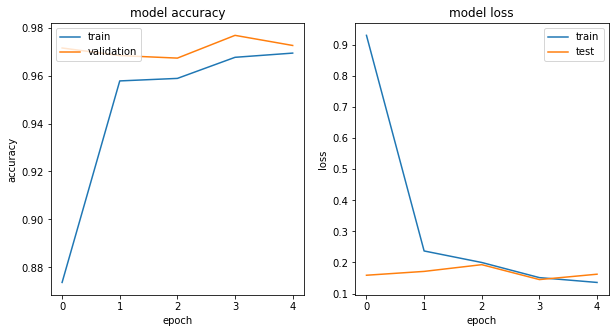

In [92]:
plot_acc_loss(history)

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
# making predictions for test data
preds = np.argmax(model_transfer.predict(test_features), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test['cluster'], preds))
print("\nNumber of correctly identified imgaes: ",
accuracy_score(test['cluster'], preds, normalize=False),"\n")
confusion_matrix(test['cluster'], preds, labels=range(0,8))


Accuracy on Test Data:  0.9683544303797469

Number of correctly identified imgaes:  918 



array([[140,   0,   0,   0,   0,   0,   0,   0],
       [  0, 120,   0,   0,   0,   0,   0,   0],
       [  0,   0, 166,   0,   0,   0,   0,   1],
       [  0,   0,   0,  94,   0,   0,   0,   0],
       [  0,   0,   0,   0, 122,   0,   0,   0],
       [  0,   0,   0,   8,   0,  82,   0,   0],
       [  0,   8,   0,   0,   0,   0, 116,   5],
       [  4,   0,   1,   0,   3,   0,   0,  78]])